In [239]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


Xử lí dữ liệu

In [240]:
# Tải dữ liệu lịch sử của cổ phiếu (ví dụ: 'AAPL' cho Apple)
ticker = 'AAPL'
data = yf.download(ticker, start="2020-01-01", end="2024-05-01")

# Tính giá trung bình
data['Price'] = data[['Open', 'Close', 'High', 'Low']].mean(axis=1)

# Chọn các cột cần thiết
data = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Price']]

# Kiểm tra giá trị bị thiếu
print(data.isna().sum())

# Xử lý giá trị bị thiếu (loại bỏ các hàng có giá trị bị thiếu)
data.dropna(inplace=True)

# Lưu dữ liệu vào tệp CSV
csv_file = f'{ticker}_historical_data.csv'
data.to_csv(csv_file)
print(f"Dữ liệu đã được lưu vào tệp {csv_file}")

# Đọc dữ liệu từ tệp CSV (Tuỳ chọn)
data_from_csv = pd.read_csv(csv_file, index_col=0)
print(data_from_csv.head())

# Chuẩn bị dữ liệu cho mô hình
prices = data_from_csv['Price'].values
volumes = data_from_csv['Volume'].values

# # Chuẩn hóa dữ liệu
# mean_price = np.mean(prices)
# std_price = np.std(prices)
# prices = (prices - mean_price) / std_price

# Split data into train and test sets
split_index = int(0.8 * len(prices))
train_prices, test_prices = prices[:split_index], prices[split_index:]
train_volumes, test_volumes = volumes[:split_index], volumes[split_index:]
train_data, test_data = data[:split_index], data[split_index:]

# Căn chỉnh dữ liệu
train_volumes = train_volumes[1:]  # Loại bỏ phần tử đầu tiên của volumes
train_prices = train_prices[:-1]   # Loại bỏ phần tử cuối cùng của prices
test_volumes = test_volumes[1:]
test_prices = test_prices[:-1]


[*********************100%%**********************]  1 of 1 completed

Open      0
High      0
Low       0
Close     0
Volume    0
Price     0
dtype: int64
Dữ liệu đã được lưu vào tệp AAPL_historical_data.csv
                 Open       High        Low      Close     Volume      Price
Date                                                                        
2020-01-02  74.059998  75.150002  73.797501  75.087502  135480400  74.523750
2020-01-03  74.287498  75.144997  74.125000  74.357498  146322800  74.478748
2020-01-06  73.447502  74.989998  73.187500  74.949997  118387200  74.143749
2020-01-07  74.959999  75.224998  74.370003  74.597504  108872000  74.788126
2020-01-08  74.290001  76.110001  74.290001  75.797501  132079200  75.121876



C:\Users\admin\AppData\Local\Temp\ipykernel_8324\681324399.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


Gradient Descent

In [241]:
import random

def predict (prices_for_predict, volumes_for_predict) :

    # Chuẩn hóa dữ liệu
    mean_price = np.mean(prices_for_predict)
    std_price = np.std(prices_for_predict)
    prices_for_predict = (prices_for_predict - mean_price) / std_price
    
    # Khởi tạo tham số
    b = random.random()
    a = random.random()
    alpha = 0.01  # Learning rate
    epochs = 1000  # Số lần lặp
    # Số lượng mẫu
    m = len(volumes_for_predict)

    # Gradient Descent
    for epoch in range(epochs):
        volumes_pred = b + a * prices_for_predict
        error = volumes_pred - volumes_for_predict
        db = (1/m) * np.sum(error)
        da = (1/m) * np.sum(error * prices_for_predict)
        
        # Kiểm tra các giá trị không hợp lệ trước khi cập nhật
        if not np.isnan(db) and not np.isnan(da):
            b -= alpha * db
            a -= alpha * da
        else:
            print(f"Encountered NaN at epoch {epoch}")
            break

    print(f"Hệ số b: {b}, hệ số a: {a}")
    return (volumes_pred, b, a)



Dự đoán

In [242]:
# Dự đoán volume sử dụng các hệ số vừa tìm được
train_volumes_pred, train_incepter, train_slope = predict(train_prices, train_volumes)

Hệ số b: 95200001.38383718, hệ số a: -36283733.83947579


Tính toán

In [243]:
# Tính tổng bình phương của các phần dư (SSR)
ssr = np.sum((train_volumes_pred - train_volumes) ** 2)
print(f"Tổng bình phương của các phần dư (SSR): {ssr}")

Tổng bình phương của các phần dư (SSR): 1.7022701245547197e+18


Sử dụng sklearn để so sánh

In [244]:
# Chuyển đổi prices thành dạng 2D cho sklearn
train_prices_reshaped = train_prices.reshape(-1, 1)
test_prices_reshaped = test_prices.reshape(-1, 1)

# Khởi tạo và huấn luyện mô hình LinearRegression của sklearn
model = LinearRegression()
model.fit(train_prices_reshaped, train_volumes)

# Dự đoán khối lượng giao dịch với sklearn
train_volumes_pred_sklearn = model.predict(train_prices_reshaped)

# Tính SSR cho mô hình sklearn
ssr_sklearn = mean_squared_error(train_volumes, train_volumes_pred_sklearn) * m
print(f"Tổng bình phương của các phần dư (SSR) với sklearn: {ssr_sklearn}")

# So sánh hệ số hồi quy
print(f"Hệ số hồi quy (intercept) với sklearn: {model.intercept_}")
print(f"Hệ số hồi quy (slope) với sklearn: {model.coef_[0]}")



Tổng bình phương của các phần dư (SSR) với sklearn: 1.702268947652845e+18
Hệ số hồi quy (intercept) với sklearn: 95229355.88305458
Hệ số hồi quy (slope) với sklearn: -36249690.962832406


Vẽ biểu đồ so sánh

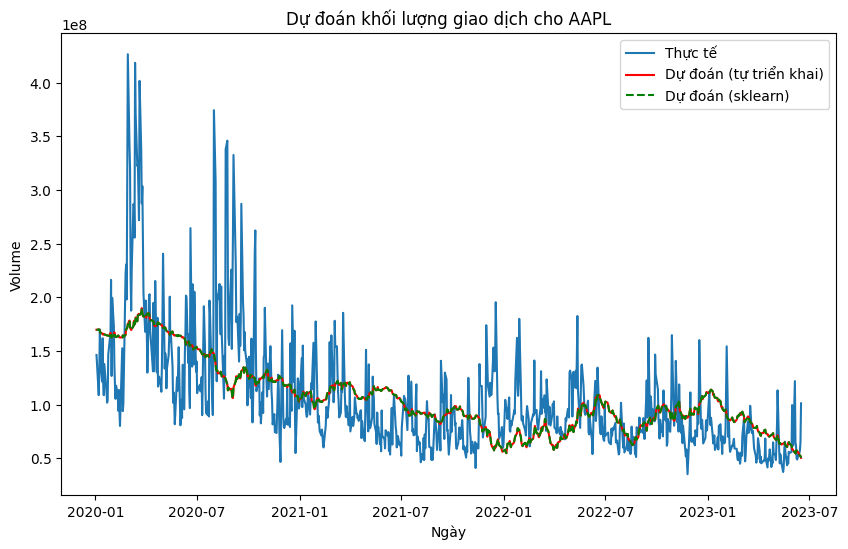

In [245]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index[1:], train_volumes, label='Thực tế')
plt.plot(train_data.index[1:], train_volumes_pred, label='Dự đoán (tự triển khai)', color='r')
plt.plot(train_data.index[1:], train_volumes_pred_sklearn, label='Dự đoán (sklearn)', color='g', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Volume')
plt.title(f'Dự đoán khối lượng giao dịch cho {ticker}')
plt.legend()
plt.show()

Evaluation

Hệ số b: 35311003.193847455, hệ số a: 18417255.873666666
                      Model  R-Squared  Adjusted R-Squared  Multiple R  \
0      Custom Least Squares  -0.170577            1.386613         NaN   
1  Sklearn LinearRegression  -0.166670            1.385322         NaN   

   Standard Error           MSE  
0    1.865014e+07  3.478276e+14  
1    1.861898e+07  3.466665e+14  


C:\Users\admin\AppData\Local\Temp\ipykernel_8324\1433231638.py:22: RuntimeWarning: invalid value encountered in sqrt
  metrics["Multiple R"].append(np.sqrt(r2))
C:\Users\admin\AppData\Local\Temp\ipykernel_8324\1433231638.py:22: RuntimeWarning: invalid value encountered in sqrt
  metrics["Multiple R"].append(np.sqrt(r2))


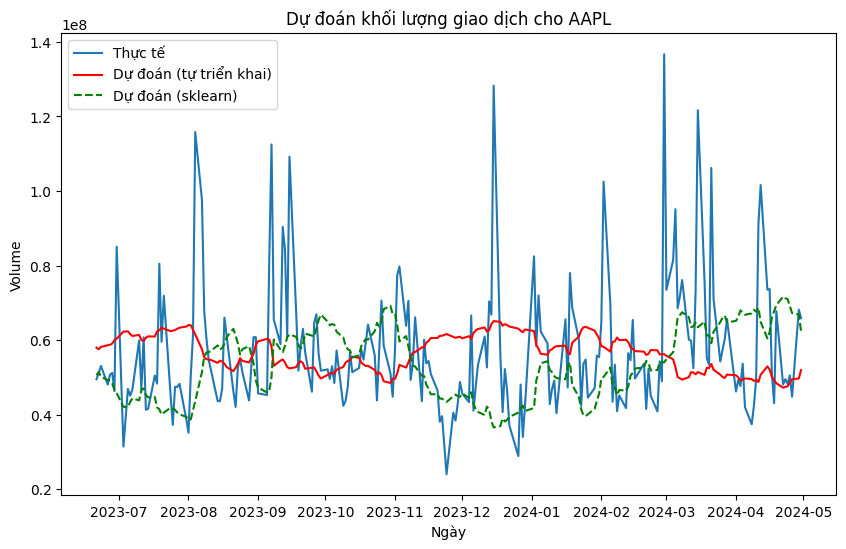

In [246]:

# Calculating evaluation metrics
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * ((n - 1) / (n - p - 1))

metrics = {
    "Model": [],
    "R-Squared": [],
    "Adjusted R-Squared": [],
    "Multiple R": [],
    "Standard Error": [],
    "MSE": []
}

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, len(y_true), len(train_volumes))
    mse = mean_squared_error(y_true, y_pred)
    std_error = np.sqrt(mse)
    metrics["Model"].append(model_name)
    metrics["R-Squared"].append(r2)
    metrics["Adjusted R-Squared"].append(adj_r2)
    metrics["Multiple R"].append(np.sqrt(r2))
    metrics["Standard Error"].append(std_error)
    metrics["MSE"].append(mse)

test_volumes_pred, test_b, test_a = predict(test_prices, test_volumes)
test_volumes_pred_sklearn = model.predict(test_prices_reshaped)


evaluate_model(test_volumes, test_volumes_pred, "Custom Least Squares")
evaluate_model(test_volumes, test_volumes_pred_sklearn, "Sklearn LinearRegression")

# Display evaluation metrics
evaluation_df = pd.DataFrame(metrics)
print(evaluation_df)

plt.figure(figsize=(10, 6))
plt.plot(test_data.index[1:], test_volumes, label='Thực tế')
plt.plot(test_data.index[1:], test_volumes_pred, label='Dự đoán (tự triển khai)', color='r')
plt.plot(test_data.index[1:], test_volumes_pred_sklearn, label='Dự đoán (sklearn)', color='g', linestyle='--')
plt.xlabel('Ngày')
plt.ylabel('Volume')
plt.title(f'Dự đoán khối lượng giao dịch cho {ticker}')
plt.legend()
plt.show()